In [26]:
#Importing required packages
from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import linregress
from scipy.signal import savgol_filter
import seaborn as sns
sns.set_style("darkgrid")

In [27]:
#Loading the data file
lc = fits.open(r'C:\Users\aswin\OneDrive\Desktop\ch2_xsm_20211111_v1_level2.lc')

In [28]:
lc.info()
#Information about data contained in the lc file

Filename: C:\Users\aswin\OneDrive\Desktop\ch2_xsm_20211111_v1_level2.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  RATE          1 BinTableHDU     64   14096R x 4C   [D, E, E, E]   


In [29]:
#Header of lc file primary
lc[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
MISSION = 'CHANDRAYAAN-2'      / Name of mission/satellite                      
TELESCOP= 'CH-2_ORBITER'       / Name of mission/satellite                      
INSTRUME= 'CH2_XSM '           / Name of Instrument/detector                    
ORIGIN  = 'PRLPOC  '           / Source of FITS file                            
CREATOR = 'xsmgenlc '          / Creator of file                                
FILENAME= 'ch2_xsm_20211111_v1_level2.lc' / Name of file                        
CONTENT = 'Light curve'     

In [30]:
#Header of lc file rate
lc[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   20 / width of table in bytes                        
NAXIS2  =                14096 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    4 / number of fields in each row                   
TTYPE1  = 'TIME    '           / label for field   1                            
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE2  = 'RATE    '           / label for field   2                            
TFORM2  = 'E       '           / data format of field: 4-byte REAL              
TTYPE3  = 'ERROR   '        

Text(0, 0.5, 'Counts')

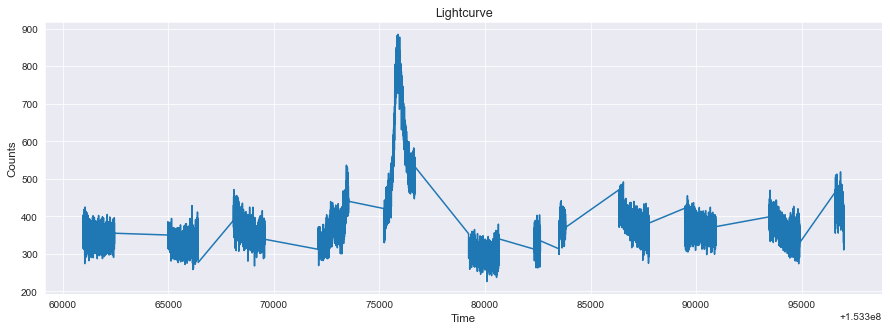

In [31]:
#Extracting count rates and time from the lc file
count_rate = lc['Rate'].data['Rate']
time = lc['Rate'].data['Time']
count_rate, time = np.array(count_rate), np.array(time)
plt.figure(0, figsize=(15,5))
plt.plot(time, count_rate)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Counts',fontsize = 11.5)

Text(0, 0.5, 'Background subtracted counts')

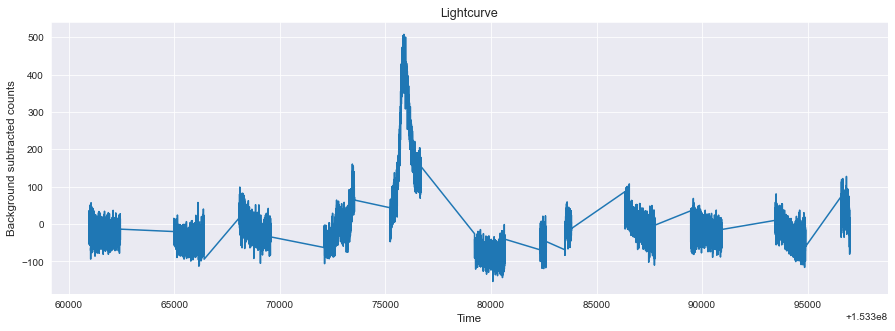

In [32]:
#Background subtraction
#Curvefit with a straight line
slope, intercept, r, p, se = linregress(time, count_rate)
bksub_counts = count_rate - np.array(slope*time+intercept)
plt.figure(0, figsize=(15,5))
plt.plot(time, bksub_counts)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Background subtracted counts',fontsize = 11.5)

Text(0, 0.5, 'Boxcar smoothed counts')

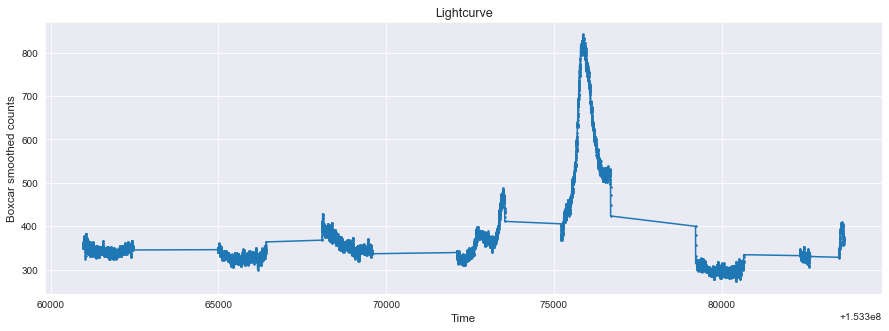

In [33]:
#box_car averaging
box_bin = 70
kernel_size = 8
box_time, box_count = np.array([]), np.array([])
for i in range(len(time[:-5000])//box_bin):
    counts = count_rate[box_bin*i+i:box_bin*(i+1)+kernel_size+1+i]
    boxavg_counts = convolve(counts, Box1DKernel(kernel_size))[kernel_size//2:box_bin+kernel_size//2+1]
    box_count = np.concatenate((box_count, boxavg_counts))
    box_time = np.concatenate((box_time, time[box_bin*i+i+kernel_size//2:box_bin*(i+1)+kernel_size//2+1+i]))
    #plt.plot(time[box_bin*i:box_bin*(i+1)+kernel_size+1], counts, marker = '.', markersize = 3, alpha = 0.1)
plt.figure(0, figsize=(15,5))
plt.plot(box_time, box_count, marker = '.', markersize = 3)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Boxcar smoothed counts',fontsize = 11.5)

Text(0, 0.5, 'Binned counts')

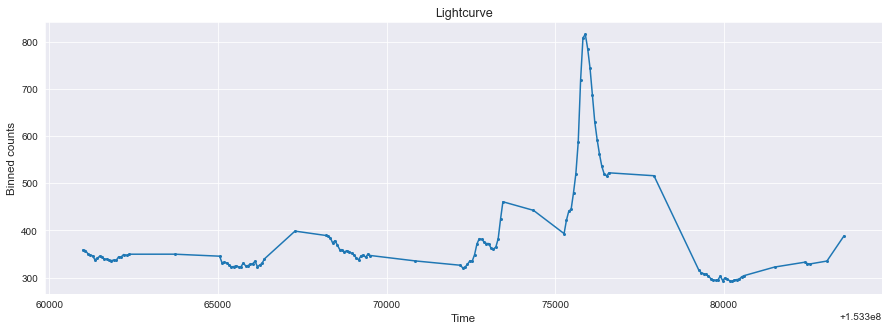

In [34]:
binned_time, binned_count = np.array([]), np.array([])
bin = 70
for i in range(len(box_time)//bin):
    binned_time = np.concatenate((binned_time, [(box_time[bin*i]+box_time[bin*(i+1)])/2]))
    binned_count = np.concatenate((binned_count, [np.average(box_count[bin*i:bin*(i+1)])]))
plt.figure(0, figsize=(15,5))
plt.plot(binned_time, binned_count, marker = '.', markersize = 4)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Binned counts',fontsize = 11.5)

1.3711083594401061
86
91


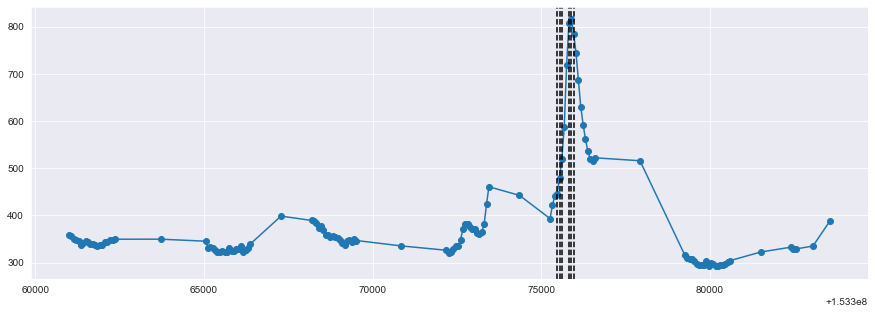

In [37]:
#Start of burst
st_nr = binned_count[4:]
st_dr = binned_count[:-4]
st_cutoff = np.average(np.sort(np.divide(st_nr, st_dr))[-10:])
st_flags = np.where(np.divide(st_nr, st_dr)>st_cutoff)
print(np.average(np.sort(np.divide(st_nr, st_dr))[-10:]))
print(st_flags[0][0])

#Peak of burst
peak = binned_count[st_flags[0][0]:]
pk_nr = peak[4:]
pk_dr = peak[:-4]
peak_flags = st_flags[0][0]+np.where(np.divide(pk_nr, pk_dr)<1)
print(peak_flags[0][0])

#End of burst
#zero_crossings = peak_flags[0][0]+np.where(np.where(np.diff(np.sign(np.divide(pk_nr, pk_dr)-1)))[0]>peak_flags[0][0])
#print(zero_crossings[0][0])

plt.figure(figsize = (15,5))
plt.plot(binned_time, binned_count,marker = 'o')

for i in range(min(len(st_flags[0]), len(peak_flags[0]))):  
    plt.axvline(binned_time[st_flags[0][i]], color = 'black', ls='--')
    plt.axvline(binned_time[peak_flags[0][i]], color = 'black', ls='--')
#plt.axvline(binned_time[zero_crossings[0][10]], color = 'red', ls='--')